tuning

1. num leafs 3

In [1]:
param = {
    #'bagging_freq': 5,
    #'bagging_fraction': 0.33,
    'boost_from_average':'false',
    'boost': 'gbdt',
    #'feature_fraction': 0.04,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    #'min_data_in_leaf': 80,
    #'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 3,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1
}

In [2]:
TRIM=False
BOX=False



In [3]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['santander-customer-transaction-prediction', 'list-of-fake-samples-and-public-private-lb-split', 'count-encoding']


In [4]:
DEBUG = False

if DEBUG:
    NROWS = 10000
else:
    NROWS = None

train_df = pd.read_csv('../input/count-encoding/train_count.csv', nrows=NROWS, index_col=0)
test_df = pd.read_csv('../input/count-encoding/test_count.csv', nrows=NROWS, index_col=0)

In [5]:
test_df.shape, train_df.shape

((100000, 401), (200000, 402))

In [6]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160_Count,var_161_Count,var_162_Count,var_163_Count,var_164_Count,var_165_Count,var_166_Count,var_167_Count,var_168_Count,var_169_Count,var_170_Count,var_171_Count,var_172_Count,var_173_Count,var_174_Count,var_175_Count,var_176_Count,var_177_Count,var_178_Count,var_179_Count,var_180_Count,var_181_Count,var_182_Count,var_183_Count,var_184_Count,var_185_Count,var_186_Count,var_187_Count,var_188_Count,var_189_Count,var_190_Count,var_191_Count,var_192_Count,var_193_Count,var_194_Count,var_195_Count,var_196_Count,var_197_Count,var_198_Count,var_199_Count
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,2.0,25.0,3.0,5.0,1.0,2.0,22.0,2.0,3.0,34.0,9.0,4.0,2.0,2.0,2.0,7.0,3.0,2.0,3.0,4.0,3.0,7.0,3.0,4.0,2.0,1.0,6.0,3.0,4.0,8.0,3.0,8.0,9.0,4.0,9.0,5.0,5.0,14.0,5.0,2.0
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,3.0,38.0,5.0,1.0,2.0,3.0,31.0,1.0,11.0,24.0,1.0,1.0,1.0,2.0,2.0,4.0,1.0,5.0,1.0,1.0,3.0,5.0,1.0,4.0,2.0,5.0,4.0,1.0,5.0,14.0,8.0,5.0,9.0,2.0,4.0,4.0,4.0,21.0,6.0,2.0
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,2.0,33.0,8.0,1.0,5.0,5.0,23.0,2.0,6.0,20.0,3.0,3.0,1.0,4.0,1.0,5.0,2.0,2.0,2.0,6.0,4.0,4.0,2.0,2.0,4.0,5.0,4.0,1.0,1.0,3.0,4.0,5.0,6.0,2.0,2.0,2.0,3.0,12.0,4.0,2.0
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,1.0,13.0,4.0,2.0,1.0,7.0,16.0,1.0,3.0,32.0,1.0,2.0,3.0,1.0,3.0,3.0,2.0,3.0,1.0,6.0,1.0,10.0,6.0,3.0,2.0,3.0,8.0,1.0,8.0,7.0,2.0,3.0,6.0,4.0,4.0,8.0,5.0,4.0,2.0,2.0
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,2.0,46.0,11.0,1.0,1.0,1.0,31.0,1.0,4.0,39.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0,1.0,4.0,6.0,4.0,8.0,3.0,1.0,2.0,2.0,3.0,1.0,2.0,10.0,3.0,8.0,1.0,1.0,1.0,9.0,5.0,9.0,2.0,2.0


In [7]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160_Count,var_161_Count,var_162_Count,var_163_Count,var_164_Count,var_165_Count,var_166_Count,var_167_Count,var_168_Count,var_169_Count,var_170_Count,var_171_Count,var_172_Count,var_173_Count,var_174_Count,var_175_Count,var_176_Count,var_177_Count,var_178_Count,var_179_Count,var_180_Count,var_181_Count,var_182_Count,var_183_Count,var_184_Count,var_185_Count,var_186_Count,var_187_Count,var_188_Count,var_189_Count,var_190_Count,var_191_Count,var_192_Count,var_193_Count,var_194_Count,var_195_Count,var_196_Count,var_197_Count,var_198_Count,var_199_Count
131076,test_131076,9.2554,-1.0297,11.1124,6.4313,11.3314,-12.7266,6.3105,16.3000,-2.3239,8.1701,-0.9194,-3.8085,13.8883,12.1832,6.8755,14.5551,7.7932,10.3964,3.9239,8.5904,12.4542,10.7429,5.5596,2.8934,10.3618,13.8781,-7.8877,-0.4800,6.7889,6.1813,-13.8250,10.0494,3.9388,17.4255,11.2187,-8.4302,6.3973,3.9340,16.1997,...,2.0,7.0,6.0,3.0,1.0,3.0,28.0,3.0,6.0,24.0,4.0,5.0,2.0,3.0,3.0,9.0,1.0,4.0,2.0,1.0,1.0,7.0,1.0,2.0,1.0,1.0,2.0,1.0,4.0,7.0,5.0,3.0,8.0,2.0,2.0,5.0,3.0,20.0,1.0,2.0
131078,test_131078,8.1264,-6.3244,12.0427,10.5956,13.0515,2.4566,3.5076,15.2741,0.2167,7.0154,-10.2625,4.0957,14.1607,7.6607,4.3894,15.0278,12.1419,-4.6530,20.3359,14.0115,9.5113,25.4857,2.1740,3.1060,5.6991,13.9659,-1.7591,-1.0374,4.5730,1.8001,-5.1953,13.2347,-0.1838,11.5452,11.4025,5.8216,-3.1038,4.7405,9.0287,...,1.0,38.0,8.0,2.0,4.0,3.0,37.0,4.0,3.0,25.0,4.0,2.0,3.0,4.0,6.0,3.0,1.0,1.0,2.0,7.0,1.0,3.0,4.0,3.0,1.0,4.0,3.0,3.0,5.0,9.0,1.0,9.0,10.0,4.0,1.0,10.0,5.0,14.0,2.0,1.0
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,7.4643,4.0355,1.6185,14.1455,9.2276,10.3202,15.1863,10.4344,-16.2784,20.4167,16.3993,26.0324,18.2594,5.8071,4.0316,19.0425,13.2969,-6.3679,0.1439,5.1571,4.2024,-7.6541,11.0271,-4.0223,14.8908,11.2465,12.2744,2.6117,3.7225,11.9105,...,3.0,44.0,11.0,4.0,2.0,1.0,19.0,1.0,4.0,31.0,5.0,5.0,1.0,2.0,2.0,3.0,2.0,2.0,2.0,5.0,3.0,4.0,4.0,4.0,2.0,3.0,6.0,2.0,4.0,4.0,5.0,3.0,9.0,3.0,2.0,2.0,2.0,5.0,1.0,4.0
131080,test_131080,11.8092,3.5175,7.2401,7.0770,11.4143,-14.7267,5.6070,12.5889,-0.4833,6.0718,-10.7962,-10.9915,13.8137,10.0909,6.2018,15.3058,8.8374,-2.3552,4.1609,10.2633,16.6368,15.3485,3.9276,3.9124,9.3382,13.4664,-1.5970,-2.5412,6.1347,1.1183,-9.3543,13.5586,-0.2889,22.3350,11.7592,1.4795,5.0948,7.9961,4.6539,...,2.0,40.0,2.0,7.0,2.0,1.0,33.0,2.0,3.0,14.0,1.0,1.0,1.0,2.0,3.0,7.0,1.0,11.0,2.0,7.0,3.0,8.0,3.0,2.0,3.0,1.0,1.0,4.0,3.0,9.0,1.0,5.0,13.0,4.0,2.0,10.0,2.0,14.0,2.0,2.0
131081,test_131081,8.5003,1.9545,7.6174,5.8388,11.2791,-9.4543,5.4782,17.9878,-1.9208,7.1584,-6.4168,0.6173,13.7854,11.3747,6.3913,14.8312,11.5819,-7.3758,12.0752,29.7073,16.9053,6.2939,0.0961,3.2577,18.1708,13.2992,-9.3249,-1.6044,5.2304,1.4325,-5.7249,13.0200,0.9294,15.0573,11.5555,6.8096,2.0852,10.0645,12.4812,...,2.0,31.0,5.0,1.0,3.0,1.0,33.0,2.0,1.0,31.0,4.0,2.0,1.0,2.0,1.0,4.0,2.0,2.0,2.0,1.0,2.0,5.0,4.0,4.0,2.0,6.0,4.0,3.0,2.0,5.0,5.0,5.0,8.0,1.0,6.0,6.0,2.0,8.0,2.0,4.0


In [8]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
no_counts = [c for c in features if c.count('Count') == 0]
counts = [c for c in features if c.count('Count') > 0]
target = train_df['target']

# Clean And Transform

In [9]:
selected_counts =[
    'var_108_Count',
    'var_12_Count',
    'var_126_Count',
    'var_148_Count',
    'var_166_Count',
    'var_91_Count',
    'var_81_Count',
    'var_133_Count',
    'var_68_Count',
    'var_125_Count',
    'var_169_Count',
]

In [10]:
# Trim outlier

def trim_outlier(df, col, threshold):
    df[col + '_Trim']=df[col] 
    df[col + '_Trim'][df[col] > threshold] = threshold

if TRIM:
    threshold = 100
    for i in [12, 108, 126]:
        col = 'var_{}_Count'.format(i)
        trim_outlier(train_df, col, threshold)
        trim_outlier(test_df, col, threshold)
    
        #assert(train_df[col].max() == threshold)
        #assert(test_df[col].max() == threshold)
    
        print ('{} max = {}, {}'.format(col, train_df[col].max(), test_df[col].max() ))
    

In [11]:
# boxcox
from scipy.stats import boxcox
if BOX:
    for col in selected_counts:
        train_df[col + '_Box'], p = boxcox(train_df[col].values)
        test_df[col + '_Box'] = boxcox(test_df[col].values, p)
        print(col, p)

In [12]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160_Count,var_161_Count,var_162_Count,var_163_Count,var_164_Count,var_165_Count,var_166_Count,var_167_Count,var_168_Count,var_169_Count,var_170_Count,var_171_Count,var_172_Count,var_173_Count,var_174_Count,var_175_Count,var_176_Count,var_177_Count,var_178_Count,var_179_Count,var_180_Count,var_181_Count,var_182_Count,var_183_Count,var_184_Count,var_185_Count,var_186_Count,var_187_Count,var_188_Count,var_189_Count,var_190_Count,var_191_Count,var_192_Count,var_193_Count,var_194_Count,var_195_Count,var_196_Count,var_197_Count,var_198_Count,var_199_Count
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,2.0,25.0,3.0,5.0,1.0,2.0,22.0,2.0,3.0,34.0,9.0,4.0,2.0,2.0,2.0,7.0,3.0,2.0,3.0,4.0,3.0,7.0,3.0,4.0,2.0,1.0,6.0,3.0,4.0,8.0,3.0,8.0,9.0,4.0,9.0,5.0,5.0,14.0,5.0,2.0
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,3.0,38.0,5.0,1.0,2.0,3.0,31.0,1.0,11.0,24.0,1.0,1.0,1.0,2.0,2.0,4.0,1.0,5.0,1.0,1.0,3.0,5.0,1.0,4.0,2.0,5.0,4.0,1.0,5.0,14.0,8.0,5.0,9.0,2.0,4.0,4.0,4.0,21.0,6.0,2.0
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,2.0,33.0,8.0,1.0,5.0,5.0,23.0,2.0,6.0,20.0,3.0,3.0,1.0,4.0,1.0,5.0,2.0,2.0,2.0,6.0,4.0,4.0,2.0,2.0,4.0,5.0,4.0,1.0,1.0,3.0,4.0,5.0,6.0,2.0,2.0,2.0,3.0,12.0,4.0,2.0
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,1.0,13.0,4.0,2.0,1.0,7.0,16.0,1.0,3.0,32.0,1.0,2.0,3.0,1.0,3.0,3.0,2.0,3.0,1.0,6.0,1.0,10.0,6.0,3.0,2.0,3.0,8.0,1.0,8.0,7.0,2.0,3.0,6.0,4.0,4.0,8.0,5.0,4.0,2.0,2.0
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,2.0,46.0,11.0,1.0,1.0,1.0,31.0,1.0,4.0,39.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0,1.0,4.0,6.0,4.0,8.0,3.0,1.0,2.0,2.0,3.0,1.0,2.0,10.0,3.0,8.0,1.0,1.0,1.0,9.0,5.0,9.0,2.0,2.0


In [13]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160_Count,var_161_Count,var_162_Count,var_163_Count,var_164_Count,var_165_Count,var_166_Count,var_167_Count,var_168_Count,var_169_Count,var_170_Count,var_171_Count,var_172_Count,var_173_Count,var_174_Count,var_175_Count,var_176_Count,var_177_Count,var_178_Count,var_179_Count,var_180_Count,var_181_Count,var_182_Count,var_183_Count,var_184_Count,var_185_Count,var_186_Count,var_187_Count,var_188_Count,var_189_Count,var_190_Count,var_191_Count,var_192_Count,var_193_Count,var_194_Count,var_195_Count,var_196_Count,var_197_Count,var_198_Count,var_199_Count
131076,test_131076,9.2554,-1.0297,11.1124,6.4313,11.3314,-12.7266,6.3105,16.3000,-2.3239,8.1701,-0.9194,-3.8085,13.8883,12.1832,6.8755,14.5551,7.7932,10.3964,3.9239,8.5904,12.4542,10.7429,5.5596,2.8934,10.3618,13.8781,-7.8877,-0.4800,6.7889,6.1813,-13.8250,10.0494,3.9388,17.4255,11.2187,-8.4302,6.3973,3.9340,16.1997,...,2.0,7.0,6.0,3.0,1.0,3.0,28.0,3.0,6.0,24.0,4.0,5.0,2.0,3.0,3.0,9.0,1.0,4.0,2.0,1.0,1.0,7.0,1.0,2.0,1.0,1.0,2.0,1.0,4.0,7.0,5.0,3.0,8.0,2.0,2.0,5.0,3.0,20.0,1.0,2.0
131078,test_131078,8.1264,-6.3244,12.0427,10.5956,13.0515,2.4566,3.5076,15.2741,0.2167,7.0154,-10.2625,4.0957,14.1607,7.6607,4.3894,15.0278,12.1419,-4.6530,20.3359,14.0115,9.5113,25.4857,2.1740,3.1060,5.6991,13.9659,-1.7591,-1.0374,4.5730,1.8001,-5.1953,13.2347,-0.1838,11.5452,11.4025,5.8216,-3.1038,4.7405,9.0287,...,1.0,38.0,8.0,2.0,4.0,3.0,37.0,4.0,3.0,25.0,4.0,2.0,3.0,4.0,6.0,3.0,1.0,1.0,2.0,7.0,1.0,3.0,4.0,3.0,1.0,4.0,3.0,3.0,5.0,9.0,1.0,9.0,10.0,4.0,1.0,10.0,5.0,14.0,2.0,1.0
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,7.4643,4.0355,1.6185,14.1455,9.2276,10.3202,15.1863,10.4344,-16.2784,20.4167,16.3993,26.0324,18.2594,5.8071,4.0316,19.0425,13.2969,-6.3679,0.1439,5.1571,4.2024,-7.6541,11.0271,-4.0223,14.8908,11.2465,12.2744,2.6117,3.7225,11.9105,...,3.0,44.0,11.0,4.0,2.0,1.0,19.0,1.0,4.0,31.0,5.0,5.0,1.0,2.0,2.0,3.0,2.0,2.0,2.0,5.0,3.0,4.0,4.0,4.0,2.0,3.0,6.0,2.0,4.0,4.0,5.0,3.0,9.0,3.0,2.0,2.0,2.0,5.0,1.0,4.0
131080,test_131080,11.8092,3.5175,7.2401,7.0770,11.4143,-14.7267,5.6070,12.5889,-0.4833,6.0718,-10.7962,-10.9915,13.8137,10.0909,6.2018,15.3058,8.8374,-2.3552,4.1609,10.2633,16.6368,15.3485,3.9276,3.9124,9.3382,13.4664,-1.5970,-2.5412,6.1347,1.1183,-9.3543,13.5586,-0.2889,22.3350,11.7592,1.4795,5.0948,7.9961,4.6539,...,2.0,40.0,2.0,7.0,2.0,1.0,33.0,2.0,3.0,14.0,1.0,1.0,1.0,2.0,3.0,7.0,1.0,11.0,2.0,7.0,3.0,8.0,3.0,2.0,3.0,1.0,1.0,4.0,3.0,9.0,1.0,5.0,13.0,4.0,2.0,10.0,2.0,14.0,2.0,2.0
131081,test_131081,8.5003,1.9545,7.6174,5.8388,11.2791,-9.4543,5.4782,17.9878,-1.9208,7.1584,-6.4168,0.6173,13.7854,11.3747,6.3913,14.8312,11.5819,-7.3758,12.0752,29.7073,16.9053,6.2939,0.0961,3.2577,18.1708,13.2992,-9.3249,-1.6044,5.2304,1.4325,-5.7249,13.0200,0.9294,15.0573,11.5555,6.8096,2.0852,10.0645,12.4812,...,2.0,31.0,5.0,1.0,3.0,1.0,33.0,2.0,1.0,31.0,4.0,2.0,1.0,2.0,1.0,4.0,2.0,2.0,2.0,1.0,2.0,5.0,4.0,4.0,2.0,6.0,4.0,3.0,2.0,5.0,5.0,5.0,8.0,1.0,6.0,6.0,2.0,8.0,2.0,4.0


In [14]:
num_round = 1000000
# check random state 44000
#n_fold = 12
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=False, random_state=12345)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

In [15]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(10, 80))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')
    
    feature_importance_df_.to_pickle('importance.pkl')

In [16]:
feature_importance_df = pd.DataFrame()

cols = [c for c in train_df.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    
    trn = train_df.iloc[trn_idx].copy()
    val = train_df.iloc[val_idx].copy()
    test = test_df.copy()
    
    trn_data = lgb.Dataset(trn[cols], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(val[cols], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3500)
    
    oof[val_idx] = clf.predict(val[cols], num_iteration=clf.best_iteration)
    
    predictions += clf.predict(test[cols], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = cols
    fold_importance_df["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.822244	valid_1's auc: 0.80792
[2000]	training's auc: 0.860237	valid_1's auc: 0.84384
[3000]	training's auc: 0.877967	valid_1's auc: 0.859857
[4000]	training's auc: 0.889125	valid_1's auc: 0.870107
[5000]	training's auc: 0.89698	valid_1's auc: 0.877283
[6000]	training's auc: 0.902653	valid_1's auc: 0.882576
[7000]	training's auc: 0.907197	valid_1's auc: 0.886915
[8000]	training's auc: 0.910787	valid_1's auc: 0.89036
[9000]	training's auc: 0.913794	valid_1's auc: 0.893205
[10000]	training's auc: 0.916358	valid_1's auc: 0.89559
[11000]	training's auc: 0.918576	valid_1's auc: 0.897688
[12000]	training's auc: 0.920495	valid_1's auc: 0.89946
[13000]	training's auc: 0.92221	valid_1's auc: 0.901001
[14000]	training's auc: 0.923744	valid_1's auc: 0.90238
[15000]	training's auc: 0.925176	valid_1's auc: 0.903584
[16000]	training's auc: 0.926516	valid_1's auc: 0.904627
[17000]	training's auc: 0.927788	v

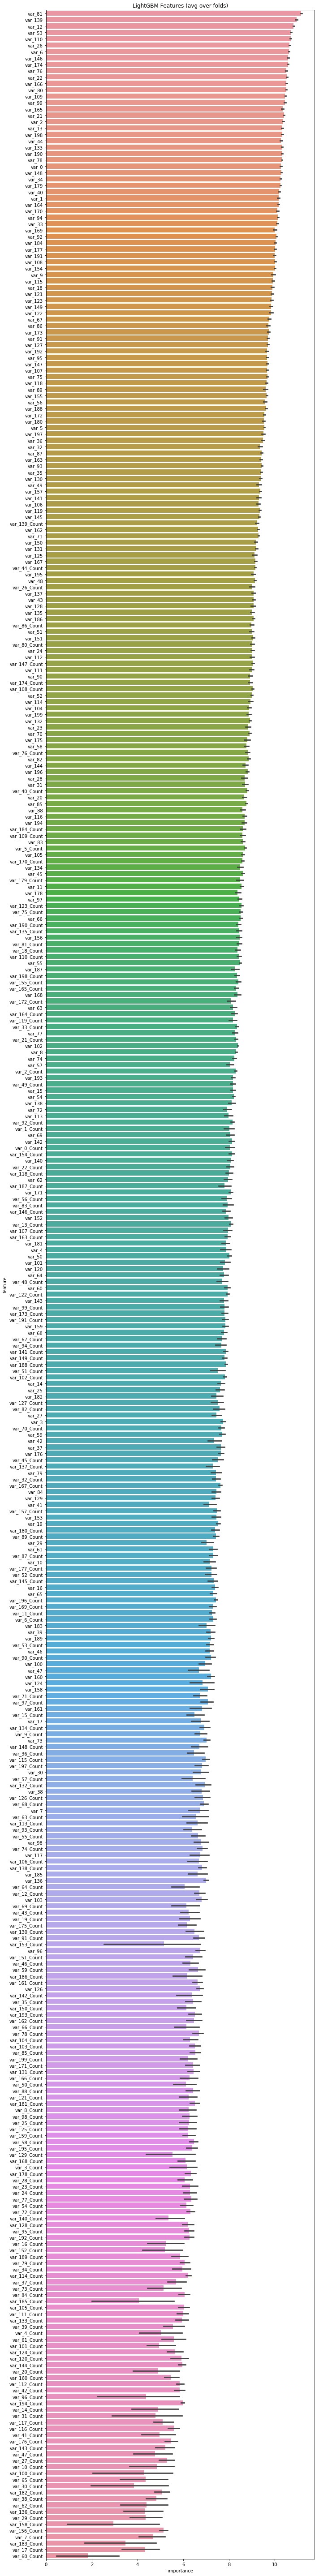

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
display_importances(feature_importance_df)

In [18]:
submission = pd.read_csv('../input/santander-customer-transaction-prediction/sample_submission.csv')
submission['target'] = 0.5
submission["target"].loc[test_df.index] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
#test_df.index
submission.iloc[test_df.index].head()


,ID_code,target
131076,test_131076,0.003336
131078,test_131078,0.009972
7,test_7,0.088492
131080,test_131080,0.200475
131081,test_131081,0.019609


# Notes

param = {
    'bagging_freq': 5,          'bagging_fraction': 0.33,   'boost_from_average':'false',   'boost': 'gbdt',
    'feature_fraction': 0.04,   'learning_rate': 0.008,     'max_depth': -1,                'metric':'auc',
    'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,           'num_threads': 8,
    'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}

**LB = 0.9**
**CV AUC = 0.90022**